# Libraries

In [1]:
!pip install python-gdcm

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import pydicom as dicom
import numpy as np
import ast
import os

import json

     |████████████████████████████████| 9.4 MB 4.5 MB/s 


# Dataset

In [2]:
ROOT_DIR = "/kaggle/input/siim-covid19-detection/"
TRAIN_DIR = ROOT_DIR + 'train/'
TEST_DIR = ROOT_DIR + 'test/'

train_image = pd.read_csv(ROOT_DIR+'train_image_level.csv')
train_study = pd.read_csv(ROOT_DIR+'train_study_level.csv')

train_study_key = train_study.id.str[:-6]
training_set = pd.merge(left = train_study, right = train_image, how = 'right', left_on = train_study_key, right_on = 'StudyInstanceUID')
#training_set.drop(['id_x'], axis = 1)
#training_set

In [3]:
def prepare_test_images():
    id_x = []
    id_y = []
    uid = []
    box = []
    label = []
    
    for d in os.listdir(TEST_DIR):
        id_x.append(d+'_study')
        uid.append(d)
        box.append(np.nan)
        label.append(np.nan)
        
        path_test = TEST_DIR + d
        path_test = path_test + '/{}/'.format(os.listdir(path_test)[0])
        
        id_y.append(os.listdir(path_test)[0].replace('.dcm','')+'_image')
            
    return id_x, id_y, box, label, uid

id_x, id_y, box, label, uid = prepare_test_images()
test_set = pd.DataFrame.from_dict({'id_x': id_x, 'id_y': id_y, 'boxes': box, 'label': label, 'StudyInstanceUID': uid})
#test_set

# Looking at images

In [4]:
def resize(img, size=768):
    return img

def normalize(img, inverse=False):
    img = img / img.max()
    img[img>1] = 1
    if inverse:
        img = 1 - img
    #print(img.min(),img.max())
    return img
    
def extract_image(data_path, dataset, i):
    path_train = data_path + dataset.loc[i, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = dataset.loc[i, 'id_y'].replace('_image','.dcm')
    if not os.path.exists(os.path.join(path_train,img_id)):
        img_id = os.listdir(path_train)[0]
    #print(img_id)
    data_file = dicom.dcmread(path_train + img_id)
    if data_file.file_meta.TransferSyntaxUID.is_compressed:
        data_file.decompress()
    img = data_file.pixel_array
    return resize(normalize(img, data_file.PhotometricInterpretation == 'MONOCHROME1')) 

def show_sample_images(data_path, dataset, sample_images, NB_SAMPLE=9):
    fig, axes = plt.subplots(3,3, figsize=(20,16))
    fig.subplots_adjust(hspace=.1, wspace=.1)
    axes = axes.ravel()

    for row,sample in enumerate(sample_images.iterrows()):
        img = extract_image(data_path, dataset, sample[0])
        if (dataset.loc[sample[0],'boxes'] == dataset.loc[sample[0],'boxes']):
            boxes = ast.literal_eval(dataset.loc[sample[0],'boxes'])
            for box in boxes:
                p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                                  box['width'], box['height'],
                                                  ec = 'r', fc = 'none', lw = 2.
                                                )
                axes[row].add_patch(p)
        axes[row].imshow(img, cmap = 'gray')
        if (dataset.loc[sample[0],'label'] == dataset.loc[sample[0],'label']):
            axes[row].set_title(dataset.loc[sample[0], 'label'].split(' ')[0])
        axes[row].set_xticklabels([])
        axes[row].set_yticklabels([])

In [5]:
NUMBER_OF_SAMPLE = 9
labels = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

#sample_negative_pneumonia = training_set[training_set[labels[0]] == 1].sample(n=NUMBER_OF_SAMPLE, random_state=42)
#show_sample_images(TRAIN_DIR, training_set, sample_negative_pneumonia, NUMBER_OF_SAMPLE)

In [6]:
#sample_test_images = test_set.sample(n=NUMBER_OF_SAMPLE, random_state=42)
#show_sample_images(TEST_DIR, test_set, sample_test_images, NUMBER_OF_SAMPLE)

# Balancing dataset

In [7]:
m = 0
for i in range(4):
    if m < len(training_set[training_set[labels[i]] == 1]):
        m = len(training_set[training_set[labels[i]] == 1])

balanced_training_set = training_set
for i in range(4):
    n = len(training_set[training_set[labels[i]] == 1])
    if n < m:
        balanced_training_set = pd.concat([balanced_training_set,training_set[training_set[labels[i]] == 1].sample(n=m-n,replace=True,random_state=42)],ignore_index=True)
        
#balanced_training_set

In [8]:
#sample_negative_pneumonia = balanced_training_set[balanced_training_set[labels[1]] == 1].sample(n=NUMBER_OF_SAMPLE, random_state=42)
#show_sample_images(TRAIN_DIR, balanced_training_set, sample_negative_pneumonia, NUMBER_OF_SAMPLE)

# Separting training and validation sets

In [9]:
train_ratio = 0.85

train_sample_negative_pneumonia = balanced_training_set[balanced_training_set[labels[0]] == 1].sample(frac=train_ratio,random_state=200)
val_sample_negative_pneumonia   = balanced_training_set[balanced_training_set[labels[0]] == 1].drop(train_sample_negative_pneumonia.index)

train_sample_typical_pneumonia = balanced_training_set[balanced_training_set[labels[1]] == 1].sample(frac=train_ratio,random_state=200)
val_sample_typical_pneumonia   = balanced_training_set[balanced_training_set[labels[1]] == 1].drop(train_sample_typical_pneumonia.index)

train_sample_indeterminate_pneumonia = balanced_training_set[balanced_training_set[labels[2]] == 1].sample(frac=train_ratio,random_state=200)
val_sample_indeterminate_pneumonia   = balanced_training_set[balanced_training_set[labels[2]] == 1].drop(train_sample_indeterminate_pneumonia.index)

train_sample_atypical_pneumonia = balanced_training_set[balanced_training_set[labels[3]] == 1].sample(frac=train_ratio,random_state=200)
val_sample_atypical_pneumonia   = balanced_training_set[balanced_training_set[labels[3]] == 1].drop(train_sample_atypical_pneumonia.index)

sample_training_set = pd.concat([train_sample_negative_pneumonia,train_sample_typical_pneumonia,train_sample_indeterminate_pneumonia,train_sample_atypical_pneumonia],ignore_index=True)
sample_val_set = pd.concat([val_sample_negative_pneumonia,val_sample_typical_pneumonia,val_sample_indeterminate_pneumonia,val_sample_atypical_pneumonia],ignore_index=True)

#sample_training_set.to_csv('./sample_training_set.csv')
#sample_val_set.to_csv('./sample_val_set.csv')

In [10]:
#sample_training_set
#sample_val_set

# Delete unused variables

In [11]:
del train_image
del train_study
del training_set
del test_set
del balanced_training_set

import gc
gc.collect()

52

# Model

In [12]:
# -*- coding: utf-8 -*-
from __future__ import division

""" 
Creates a ResNeXt Model as defined in:

Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2016). 
Aggregated residual transformations for deep neural networks. 
arXiv preprint arXiv:1611.05431.

"""

__author__ = "Pau Rodríguez López, ISELAB, CVC-UAB"
__email__ = "pau.rodri1@gmail.com"

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

class ResNeXtBottleneck(nn.Module):
    """
    RexNeXt bottleneck type C (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
    """

    def __init__(self, in_channels, out_channels, stride, cardinality, base_width, widen_factor):
        """ Constructor

        Args:
            in_channels: input channel dimensionality
            out_channels: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            cardinality: num of convolution groups.
            base_width: base number of channels in each group.
            widen_factor: factor to reduce the input dimensionality before convolution.
        """
        super(ResNeXtBottleneck, self).__init__()
        width_ratio = out_channels / (widen_factor * 64.)
        D = cardinality * int(base_width * width_ratio)
        self.conv_reduce = nn.Conv2d(in_channels, D, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_reduce = nn.BatchNorm2d(D)
        self.conv_conv = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn = nn.BatchNorm2d(D)
        self.conv_expand = nn.Conv2d(D, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_expand = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module('shortcut_conv',
                                     nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0,
                                               bias=False))
            self.shortcut.add_module('shortcut_bn', nn.BatchNorm2d(out_channels))

    def forward(self, x):
        bottleneck = self.conv_reduce.forward(x)
        bottleneck = F.relu(self.bn_reduce.forward(bottleneck), inplace=True)
        bottleneck = self.conv_conv.forward(bottleneck)
        bottleneck = F.relu(self.bn.forward(bottleneck), inplace=True)
        bottleneck = self.conv_expand.forward(bottleneck)
        bottleneck = self.bn_expand.forward(bottleneck)
        residual = self.shortcut.forward(x)
        return F.relu(residual + bottleneck, inplace=True)


class CifarResNeXt(nn.Module):
    """
    ResNext optimized for the Cifar dataset, as specified in
    https://arxiv.org/pdf/1611.05431.pdf
    """

    def __init__(self, cardinality, depth, nlabels, base_width, widen_factor=4):
        """ Constructor

        Args:
            cardinality: number of convolution groups.
            depth: number of layers.
            nlabels: number of classes
            base_width: base number of channels in each group.
            widen_factor: factor to adjust the channel dimensionality
        """
        super(CifarResNeXt, self).__init__()
        self.cardinality = cardinality
        self.depth = depth
        self.block_depth = (self.depth - 2) // 9
        self.base_width = base_width
        self.widen_factor = widen_factor
        self.nlabels = nlabels
        self.output_size = 64
        self.stages = [64, 64 * self.widen_factor, 128 * self.widen_factor, 256 * self.widen_factor]

        #self.conv_1_3x3 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.conv_1_3x3 = nn.Conv2d(1, 64, 3, 1, 1, bias=False)
        self.bn_1 = nn.BatchNorm2d(64)
        self.stage_1 = self.block('stage_1', self.stages[0], self.stages[1], 1)
        self.stage_2 = self.block('stage_2', self.stages[1], self.stages[2], 2)
        self.stage_3 = self.block('stage_3', self.stages[2], self.stages[3], 2)
        self.classifier = nn.Linear(self.stages[3], nlabels)
        init.kaiming_normal(self.classifier.weight)

        for key in self.state_dict():
            if key.split('.')[-1] == 'weight':
                if 'conv' in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if 'bn' in key:
                    self.state_dict()[key][...] = 1
            elif key.split('.')[-1] == 'bias':
                self.state_dict()[key][...] = 0

    def block(self, name, in_channels, out_channels, pool_stride=2):
        """ Stack n bottleneck modules where n is inferred from the depth of the network.

        Args:
            name: string name of the current block.
            in_channels: number of input channels
            out_channels: number of output channels
            pool_stride: factor to reduce the spatial dimensionality in the first bottleneck of the block.

        Returns: a Module consisting of n sequential bottlenecks.

        """
        block = nn.Sequential()
        for bottleneck in range(self.block_depth):
            name_ = '%s_bottleneck_%d' % (name, bottleneck)
            if bottleneck == 0:
                block.add_module(name_, ResNeXtBottleneck(in_channels, out_channels, pool_stride, self.cardinality,
                                                          self.base_width, self.widen_factor))
            else:
                block.add_module(name_,
                                 ResNeXtBottleneck(out_channels, out_channels, 1, self.cardinality, self.base_width,
                                                   self.widen_factor))
        return block

    def forward(self, x):
        x = self.conv_1_3x3.forward(x)
        x = F.relu(self.bn_1.forward(x), inplace=True)
        x = self.stage_1.forward(x)
        x = self.stage_2.forward(x)
        x = self.stage_3.forward(x)
        x = F.avg_pool2d(x, 32, 1)
        x = x.view(-1, self.stages[3])
        return self.classifier(x)

# Training Environment

In [13]:
#!pip install GPUtil

#from GPUtil import showUtilization as gpu_usage
#gpu_usage()
#torch.cuda.empty_cache()

In [14]:
state = {
    'input_size': 128,
    'epochs':     5,
    'batch_size': 8,  # multiplication of 4
    'learning_rate': 0.01,
    'momentum': 0.9,
    'decay': 0.0005,   # weight decaly (L2 penalty)
    'test_bs': 10,
    'schedule': [150,225],   # decrease learning rate at these epochs
    'gamma': 0.1,
    'save': './ckpt', # folder to save checkpoints
    'load': './ckpt', # checkpoint path to resume
    'test_only': False,
    'depth': 29,  # model depth
    'cardinality': 8, # model cardinality (group)
    'base_width': 64, # number of channels in each group
    'widen_factor': 4, # widen factor 4->64, 8->128, ...
    'ngpu': 1, # 0=cpu
    'prefetch': 2, # prefetching threads
    'log': './logs' # log folder
}

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

if not os.path.isdir(state['log']):
    os.makedirs(state['log'])

log = open(os.path.join(state['log'], 'log.txt'), 'w')
log.write(json.dumps(state) + '\n')
    
state['epochs'] = state['epochs'] * state['batch_size']
state['schedule'] = [x * state['batch_size'] // state['batch_size'] for x in state['schedule']]

if not os.path.isdir(state['save']):
    os.makedirs(state['save'])

nlabels = 5
net = CifarResNeXt(state['cardinality'], state['depth'], nlabels, 
                   state['base_width'], state['widen_factor'])

print(net)

if state['ngpu'] > 1:
    net = torch.nn.DataParallel(net, device_ids=list(range(args.ngpu)))
if state['ngpu'] > 0:
    net.cuda()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

optimizer = torch.optim.SGD(net.parameters(), state['learning_rate'], momentum=state['momentum'],
                            weight_decay=state['decay'], nesterov=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


CifarResNeXt(
  (conv_1_3x3): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage_1): Sequential(
    (stage_1_bottleneck_0): ResNeXtBottleneck(
      (conv_reduce): Conv2d(64, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_reduce): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_expand): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_expand): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (shortcut_conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (shortcut_bn): BatchNorm2d(256, ep

/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


# Dataloader with augmentation

In [16]:
from skimage import exposure
import cv2

class TDataset(Dataset):
    def __init__(self, data_path, labeled_data, transforms=None, new_size=(512, 512)):
        self.data_path = data_path
        self.labeled_data = labeled_data
        self.new_size = new_size
        self.transforms = transforms
        
    def get_label(self, dataset, idx):
        def opacity(label):
            return 1 if label=='opacity' else 0
        return np.array([dataset.loc[idx, 'Negative for Pneumonia'],
                         dataset.loc[idx, 'Typical Appearance'],
                         dataset.loc[idx, 'Indeterminate Appearance'],
                         dataset.loc[idx, 'Atypical Appearance'],
                         opacity(dataset.loc[idx, 'label'].split(' ')[0])],dtype=np.float32)
        
    def __len__(self):
        return len(self.labeled_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = extract_image(self.data_path, self.labeled_data, idx)
        image = exposure.equalize_hist(image)
        label = self.get_label(self.labeled_data, idx)
        
        good_height, good_width = self.new_size
        image = cv2.resize(image, (good_width, good_height), interpolation=cv2.INTER_CUBIC)
        #mask  = image
        
        if self.transforms:
            #transformed = self.transforms(image=image.astype(np.float32), mask=mask.astype(np.float32))
            transformed = self.transforms(image=image.astype(np.float32))
            image = transformed['image']
            image[image>1] = 1
            image[image<0] = 0
            #mask  = transformed['mask']
        
        return image, label
    
class SDataset(Dataset):
    def __init__(self, data_path, test_data, transforms=None, new_size=(512, 512)):
        self.data_path = data_path
        self.test_data = test_data
        self.new_size = new_size
        self.transforms = transforms
        
    def __len__(self):
        return len(self.test_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = extract_image(self.data_path, self.test_data, idx)
        image = exposure.equalize_hist(image)
        
        good_height, good_width = self.new_size
        image = cv2.resize(image, (good_width, good_height), interpolation=cv2.INTER_CUBIC)
        
        if self.transforms:
            transformed = self.transforms(image=image.astype(np.float32))
            image = transformed['image']
            image[image>1] = 1
            image[image<0] = 0
            
        return image
    
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.2], 
                                                        contrast_limit=[-0.2, 0.2], 
                                                        p=0.5),
                             A.ShiftScaleRotate(scale_limit=[-0.1, 0.3], 
                                                shift_limit=0.1, 
                                                rotate_limit=20, 
                                                border_mode=cv2.BORDER_CONSTANT,
                                                p=0.5),
                             # reshape image of size (k, n, 1) into (1, k, n)
                             ToTensorV2(p=1.0)
                            ])

test_transform = A.Compose([ToTensorV2(p=1.0)])

In [17]:
loader_sample_training_set = TDataset(data_path=TRAIN_DIR,
                                      labeled_data=sample_training_set,
                                      transforms=train_transform,
                                      new_size=(state['input_size'], state['input_size']))

loader_sample_val_set = TDataset(data_path=TRAIN_DIR,
                                 labeled_data=sample_val_set,
                                 transforms=train_transform,
                                 new_size=(state['input_size'], state['input_size']))

train_dataloader = DataLoader(loader_sample_training_set, batch_size=state['batch_size'], shuffle=True, num_workers=state['prefetch'])
val_dataloader   = DataLoader(loader_sample_val_set, batch_size=state['batch_size'], shuffle=True, num_workers=state['prefetch'])

In [18]:
def get_label_names(idx,labels):
    label = []
    
    if labels[0] == 1:
        label.append('Negative for Pneumonia')
    if labels[1] == 1:
        label.append('Typical Appearance')
    if labels[2] == 1:
        label.append('Indeterminate Appearance')
    if labels[3] == 1:
        label.append('Atypical Appearance')
    if labels[4] == 0:
        label.append('None')
    else:
        label.append('Opacity')
        
    return '|'.join(label)
        
def show_augmented_images(dataloader, batch_size=8, train=True):
    w = 5 * int(batch_size/4)
    h = 5 * 4
    fig, axes = plt.subplots(int(batch_size/4),4, figsize=(h,w))
    fig.subplots_adjust(hspace=.1, wspace=.1)
    axes = axes.ravel()
    
    dataiter = iter(dataloader)
    image, label = dataiter.next()
    
    for i in range(batch_size):
        axes[i].imshow(image[i].squeeze(), cmap = 'gray')
        if train:
            axes[i].set_title(get_label_names(i,label[i]))
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])

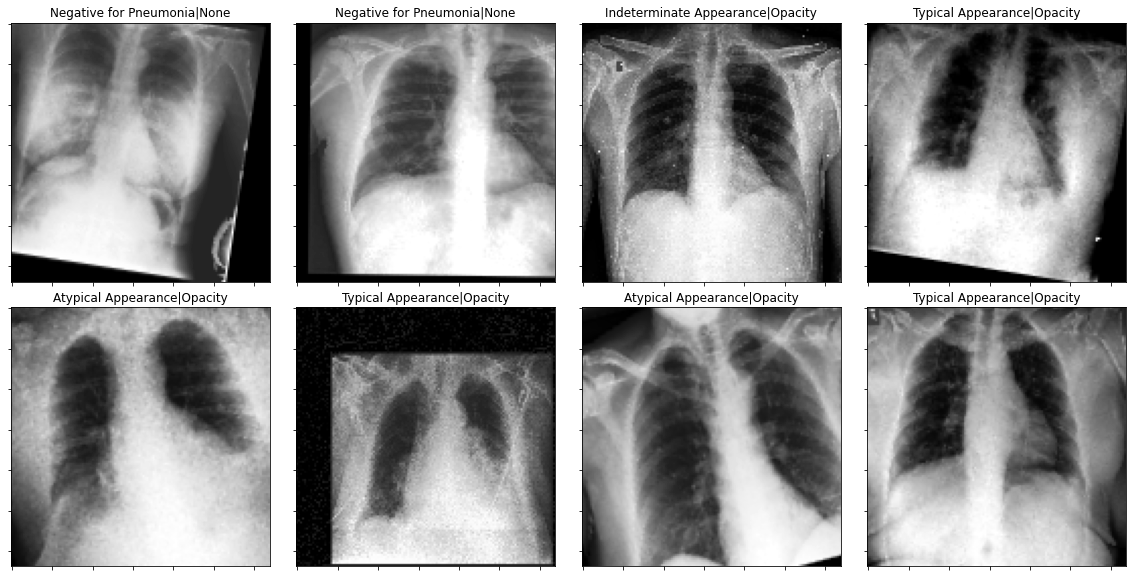

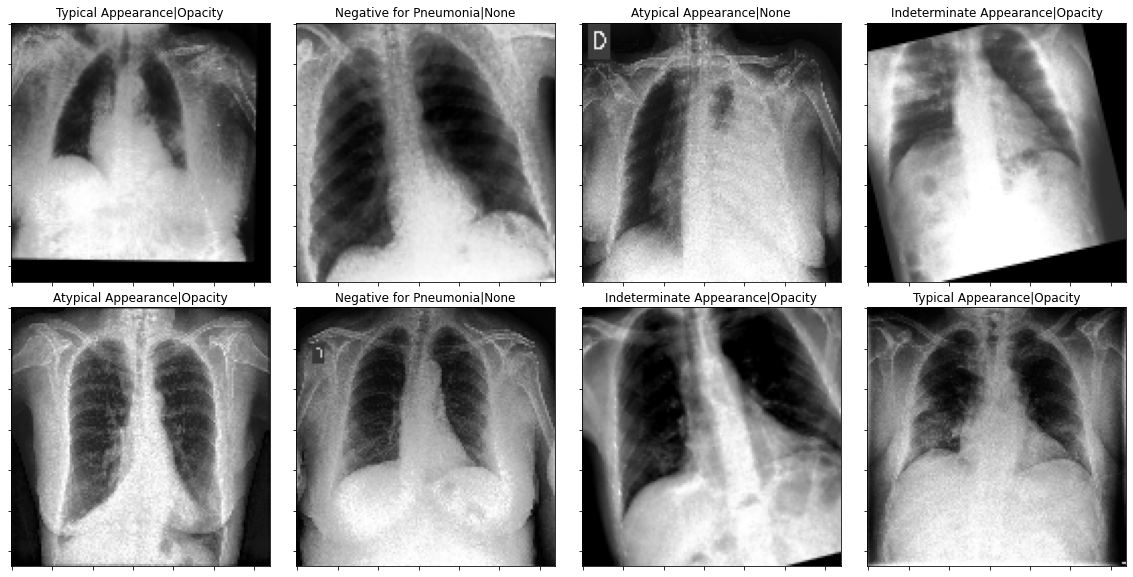

In [19]:
show_augmented_images(train_dataloader, batch_size=state['batch_size'])
show_augmented_images(val_dataloader, batch_size=state['batch_size'])

# Training

In [20]:
from tqdm import tqdm
import time

# train function (forward, backward, update)
def train():
    since = time.time()
    net.train()
    loss_avg = 0.0
    tqdm_loader = tqdm(train_dataloader, total=int(len(train_dataloader)))
    for batch_idx, (data, target) in enumerate(tqdm_loader):
        data, target = torch.autograd.Variable(data.cuda()), torch.autograd.Variable(target.cuda())

        # forward
        output = net(data)
        
        # loss
        #criterion = F.cross_entropy()
        criterion = nn.MultiLabelSoftMarginLoss()
        #criterion = nn.BCEWithLogitsLoss()
        
        # backward
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # exponential moving average
        loss_avg = loss_avg * 0.2 + float(loss) * 0.8
        #print('Training Loss: {:.4f}'.format(loss_avg))

    state['train_loss'] = loss_avg
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# test function (forward only)
def test():
    net.eval()
    loss_avg = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(val_dataloader):
        data, target = torch.autograd.Variable(data.cuda()), torch.autograd.Variable(target.cuda())
        
        # loss
        #criterion = F.cross_entropy()
        criterion = nn.MultiLabelSoftMarginLoss()
        #criterion = nn.BCEWithLogitsLoss()
        
        # forward
        output = net(data)
        loss = criterion(output, target)

        # accuracy
        pred = output.data.max(1)[1]
        correct += float(pred.eq(target.data).sum())

        # test loss average
        loss_avg += float(loss)

    state['test_loss'] = loss_avg / len(test_loader)
    state['test_accuracy'] = correct / len(test_loader.dataset)
    
def draw():
    file = open('./logs/log.txt','r')
    accuracy = []
    epochs = []
    loss = []
    for line in file:
        test_accuracy = re.search('"test_accuracy": ([0]\.[0-9]+)*', line)
        if test_accuracy:
            accuracy.append(test_accuracy.group(1))
        
        epoch = re.search('"epoch": ([0-9]+)*', line)
        if epoch:
            epochs.append(epoch.group(1))
        
        train_loss = re.search('"train_loss": ([0-9]\.[0-9]+)*', line)
        if train_loss:
            loss.append(train_loss.group(1))
    file.close()
    plt.figure('test_accuracy vs epochs')  
    plt.xlabel('epoch')
    plt.ylabel('test_accuracy')
    plt.plot(epochs,accuracy,'b*')
    plt.plot(epochs,accuracy,'r')
    plt.grid(True)

    plt.figure('train_loss vs epochs')
    plt.xlabel('epoch')
    plt.ylabel('train_loss')
    plt.plot(epochs,loss,'b*')
    plt.plot(epochs,loss,'y')
    plt.grid(True)

    plt.show()

In [21]:
# Main loop
best_accuracy = 0.0
for epoch in range(state['epochs']):
    if epoch in state['schedule']:
        state['learning_rate'] *= state['gamma']
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['learning_rate']

    state['epoch'] = epoch
    train()
    test()
    if state['test_accuracy'] > best_accuracy:
        best_accuracy = state['test_accuracy']
        torch.save(net.state_dict(), os.path.join(args.save, 'model.pytorch'))
    log.write('%s\n' % json.dumps(state))
    log.flush()
    print(state)
    print("Best accuracy: %f" % best_accuracy)

log.close()

 51%|█████     | 648/1278 [37:01<27:54,  2.66s/it]/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)
100%|██████████| 1278/1278 [1:12:37<00:00,  3.41s/it]

Training complete in 72m 38s


RuntimeError: The size of tensor a (8) must match the size of tensor b (5) at non-singleton dimension 1

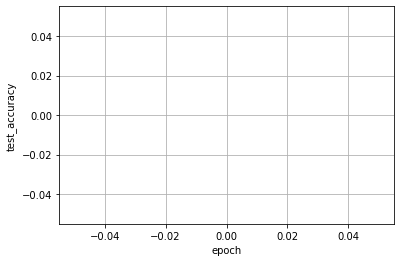

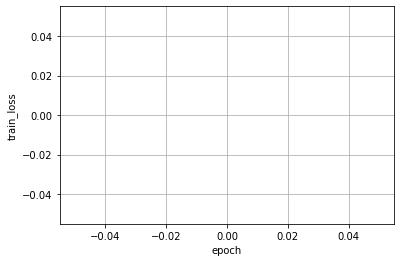

In [22]:
draw()

# Submission

In [23]:
def simple_submission():
    df = pd.read_csv(ROOT_DIR + "sample_submission.csv")
    df.to_csv('./submission.csv',index=False)
    print(df)
    
def random_submission():
    pass

simple_submission()
#random_submission()

                      id    PredictionString
0     00188a671292_study  negative 1 0 0 1 1
1     004bd59708be_study  negative 1 0 0 1 1
2     00508faccd39_study  negative 1 0 0 1 1
3     006486aa80b2_study  negative 1 0 0 1 1
4     00655178fdfc_study  negative 1 0 0 1 1
...                  ...                 ...
2472  46719b856de1_image      none 1 0 0 1 1
2473  31c07523a69a_image      none 1 0 0 1 1
2474  f77d7d1aebab_image      none 1 0 0 1 1
2475  ccc5b63ca96d_image      none 1 0 0 1 1
2476  5e8ac1fe2b82_image      none 1 0 0 1 1

[2477 rows x 2 columns]
